In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nptdms import TdmsFile

# Data Load

In [2]:
file_path = '../data/250516_02.tdms'

tdms = TdmsFile.read(file_path)

print("✅ Available groups and channels:")
group_channel_map = {}
for grp in tdms.groups():
    name = grp.name
    channels = [ch.name for ch in grp.channels()]
    group_channel_map[name] = channels
    print(f" - Group: {name}")
    for ch in channels:
        print(f"    • {ch}")

✅ Available groups and channels:
 - Group: Datas
    • Time (ms)
    • Reference Position X
    • Reference Position Y
    • Measured Position X
    • Measured Position Y
    • Reference Tension L
    • Reference Tension R
    • Reference Tension T
    • Measured Tension L
    • Measured Tension R
    • Measured Tension T
    • RBF1
    • RBF2
    • RBF3
    • Trajectory
    • Performance
    • Force X
    • Force y
    • Damp1
    • Damp2
    • Damp3


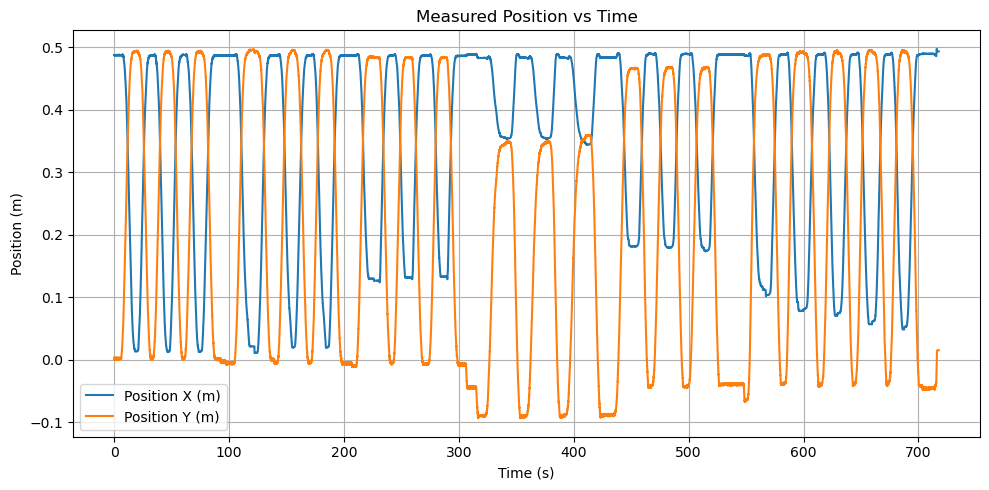

In [3]:
group    = 'Datas' if 'Datas' in [g.name for g in tdms.groups()] else tdms.groups()[0].name

# --- 2) Measured Position 채널 로드 (mm 단위로 들어온다면 변환) --------------------
pos_x_mm = tdms[group]['Measured Position X'][:]   # [mm]
pos_y_mm = tdms[group]['Measured Position Y'][:]   # [mm]
time     = np.arange(len(pos_x_mm)) / 50            # sample_rate=50 Hz

# mm → m 로 변환 (원하시면 주석 처리)
pos_x = pos_x_mm * 1e-3   # [m]
pos_y = pos_y_mm * 1e-3   # [m]

# --- 3) 그래프 그리기 ----------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(time, pos_x, color='C0', label='Position X (m)')
plt.plot(time, pos_y, color='C1', label='Position Y (m)')
plt.title('Measured Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


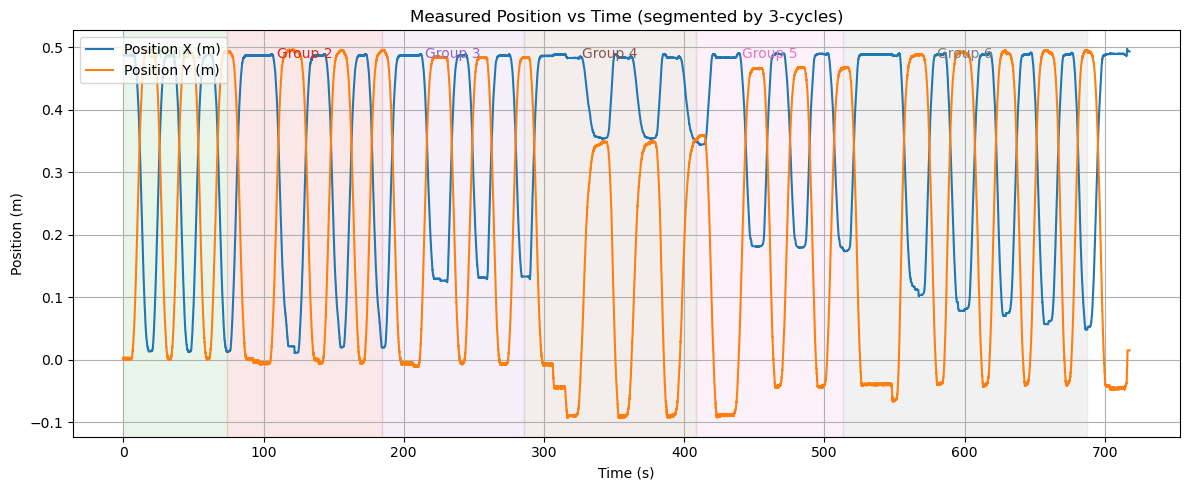

In [4]:
pos_x_mm = tdms[group]['Measured Position X'][:]   # [mm]
pos_y_mm = tdms[group]['Measured Position Y'][:]   # [mm]
traj     = tdms[group]['Trajectory'][:]            # 0/1
dt       = 1/50                                    # s

time = np.arange(len(pos_x_mm)) * dt
pos_x = pos_x_mm * 1e-3  # → [m]
pos_y = pos_y_mm * 1e-3  # → [m]

# 2) falling edge 인덱스 → 그룹 분할 --------------------------------------------
edges = np.where((traj[:-1] == 1) & (traj[1:] == 0))[0] + 1
group_sizes = [3,3,3,3,3,None]
groups, pos = [], 0
for sz in group_sizes:
    if sz is None:
        groups.append(edges[pos:])
    else:
        groups.append(edges[pos:pos+sz])
        pos += sz

# 3) 그래프 그리기 + 구간별 음영 ------------------------------------------------
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(time, pos_x, label='Position X (m)', color='C0')
ax.plot(time, pos_y, label='Position Y (m)', color='C1')

# 그룹별 시작·끝 시각 구하기 & 음영·라벨링
for i, grp in enumerate(groups, start=1):
    if len(grp)==0: 
        continue
    start_idx = 0 if i==1 else groups[i-2][-1]
    end_idx   = grp[-1]
    t0, t1    = start_idx*dt, end_idx*dt

    # 반투명 음영
    ax.axvspan(t0, t1, color=f'C{i+1}', alpha=0.1)
    # 그룹 번호 라벨
    y_max = ax.get_ylim()[1]
    ax.text((t0+t1)/2, y_max*0.95, f'Group {i}', 
            ha='center', va='top', fontsize=10, color=f'C{i+1}')

ax.set_title('Measured Position vs Time (segmented by 3-cycles)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Position (m)')
ax.legend(loc='upper left')
ax.grid(True)
plt.tight_layout()
plt.show()


Stiffness : 0.8,0.8,0.8,0.05,0.1,ANN

Arm : X,5,10,5,5,5

# Trajectory Tracking

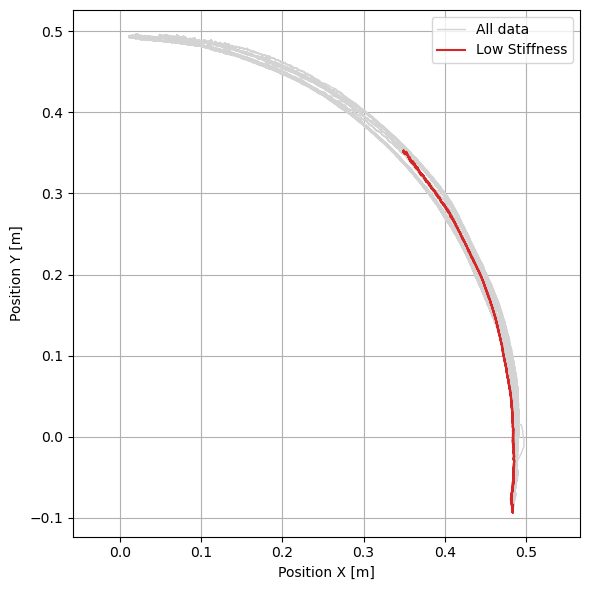

In [51]:
# --- 보고 싶은 그룹 인덱스만 설정하세요 ---
group_idx = 3   # 0이면 G1, 1이면 G2, …

# Group 1→0 falling edge로 나눈 인덱스
ends      = groups[group_idx]
start_idx = 0 if group_idx==0 else groups[group_idx-1][-1]
end_idx   = ends[-1]

idxs = np.arange(len(pos_x))
mask = (idxs>=start_idx) & (idxs<=end_idx) & (traj==1)

# 전체 경로 (회색)
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(pos_x, pos_y, color='lightgray', linewidth=1, label='All data')

# mask==False 구간을 NaN으로 만들어 선을 끊기
x_vis = pos_x.copy()
y_vis = pos_y.copy()
x_vis[~mask] = np.nan
y_vis[~mask] = np.nan

ax.plot(x_vis, y_vis, linestyle='-',
        color='C3', label=f'Low Stiffness')

ax.set_xlabel('Position X [m]')
ax.set_ylabel('Position Y [m]')
# ax.set_title(f'Spatial Trajectory')
ax.legend()
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.3, 0.3)
ax.axis('equal')
ax.grid(True)
plt.tight_layout()
plt.show()


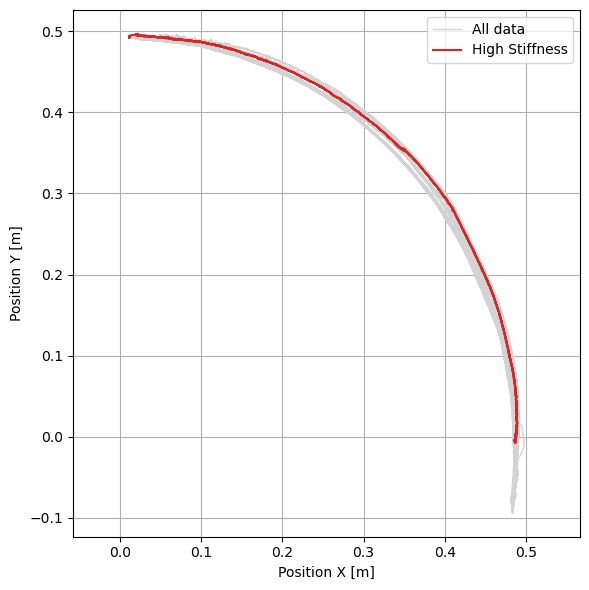

In [54]:
# --- 보고 싶은 그룹 인덱스만 설정하세요 ---
group_idx = 1   # 0이면 G1, 1이면 G2, …

# Group 1→0 falling edge로 나눈 인덱스
ends      = groups[group_idx]
start_idx = 0 if group_idx==0 else groups[group_idx-1][-1]
end_idx   = ends[-1]

idxs = np.arange(len(pos_x))
mask = (idxs>=start_idx) & (idxs<=end_idx) & (traj==1)

# 전체 경로 (회색)
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(pos_x, pos_y, color='lightgray', linewidth=1, label='All data')

# mask==False 구간을 NaN으로 만들어 선을 끊기
x_vis = pos_x.copy()
y_vis = pos_y.copy()
x_vis[~mask] = np.nan
y_vis[~mask] = np.nan

ax.plot(x_vis, y_vis, linestyle='-',
        color='C3', label=f'High Stiffness')

ax.set_xlabel('Position X [m]')
ax.set_ylabel('Position Y [m]')
# ax.set_title(f'Spatial Trajectory')
ax.legend()
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.3, 0.3)
ax.axis('equal')
ax.grid(True)
plt.tight_layout()
plt.show()


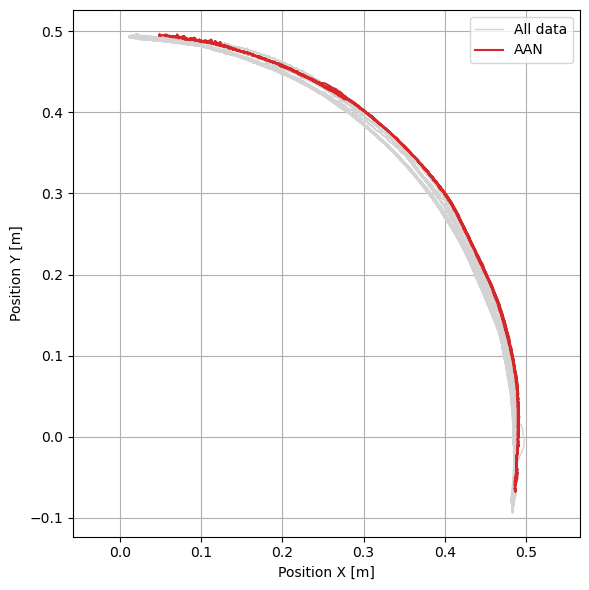

In [57]:
# --- 보고 싶은 그룹 인덱스만 설정하세요 ---
group_idx = 5   # 0이면 G1, 1이면 G2, …

# Group 1→0 falling edge로 나눈 인덱스
ends      = groups[group_idx]
start_idx = 0 if group_idx==0 else groups[group_idx-1][-1]
end_idx   = ends[-1]

idxs = np.arange(len(pos_x))
mask = (idxs>=start_idx) & (idxs<=end_idx) & (traj==1)

# 전체 경로 (회색)
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(pos_x, pos_y, color='lightgray', linewidth=1, label='All data')

# mask==False 구간을 NaN으로 만들어 선을 끊기
x_vis = pos_x.copy()
y_vis = pos_y.copy()
x_vis[~mask] = np.nan
y_vis[~mask] = np.nan

ax.plot(x_vis, y_vis, linestyle='-',
        color='C3', label=f'AAN')

ax.set_xlabel('Position X [m]')
ax.set_ylabel('Position Y [m]')
# ax.set_title(f'Spatial Trajectory')
ax.legend()
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.3, 0.3)
ax.axis('equal')
ax.grid(True)
plt.tight_layout()
plt.show()


# Force Estimation

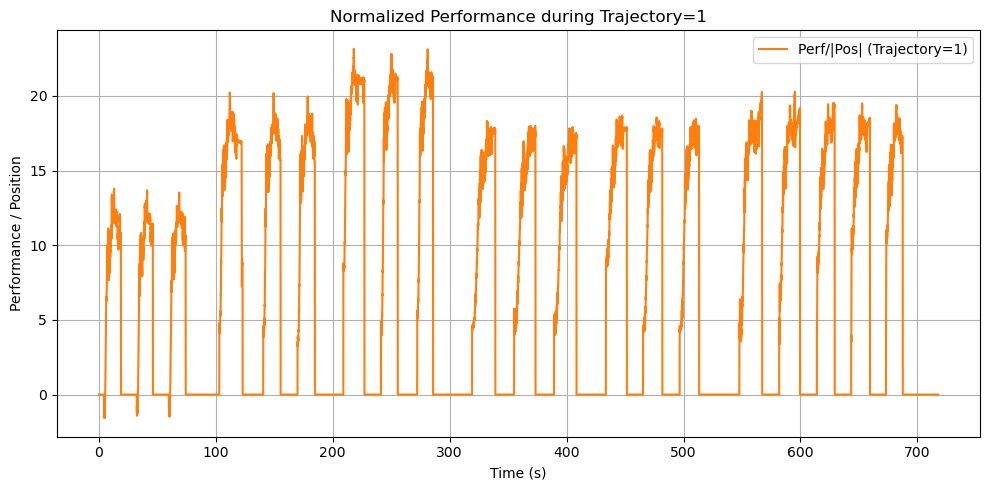

In [58]:
# 2) Performance & Position(X,Y) 로드 → 정규화 → Raw 시각화
perf = tdms[group]['Performance'][:]            # 원본 Performance

# 시간 축
time = np.arange(len(perf)) / 50                    # sample_rate = 50 Hz

# 3) Trajectory=1 구간만 마스킹하여 시각화
traj = tdms[group]['Trajectory'][:]          # Trajectory 로드
mask = (traj == 1)                           # Traj=1 위치만 True

# Traj=1 구간만 perf, 나머지는 0 또는 np.nan 처리
perf_traj = np.where(mask, perf, 0)

plt.figure(figsize=(10,5))
plt.plot(time, perf_traj, color='C1', label='Perf/|Pos| (Trajectory=1)')
plt.title('Normalized Performance during Trajectory=1')
plt.xlabel('Time (s)')
plt.ylabel('Performance / Position')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# # 2) offset
# perf_off = perf_traj - 12

# # 3) 0 이하 제거
# perf_off_clipped = np.where(perf_off>0, perf_off, 0)

# # 4) 플롯
# plt.figure(figsize=(10,5))
# plt.plot(time, perf_off_clipped, color='C1',
#          label='Perf (traj=1) – 14, clipped at 0')
# plt.title('Normalized Performance during Trajectory=1 (offset & clip)')
# plt.xlabel('Time (s)')
# plt.ylabel('Performance / Position')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


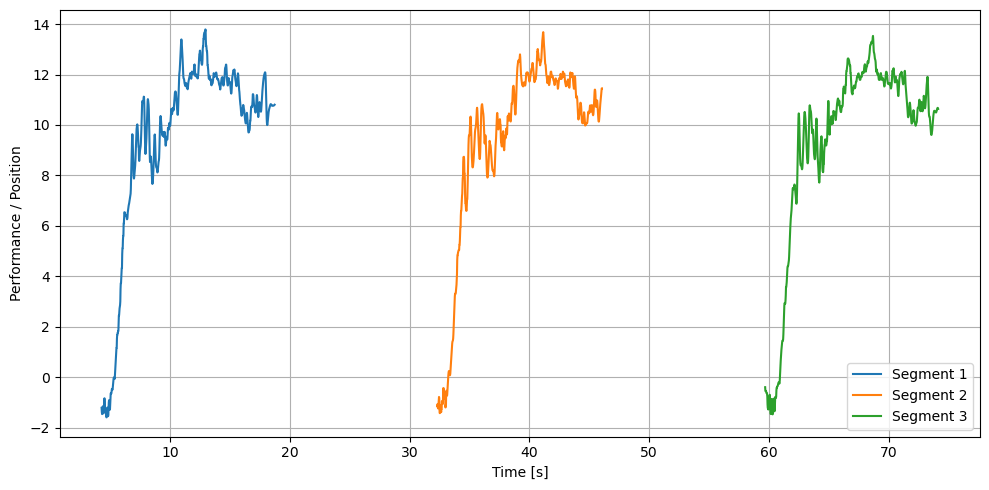

In [59]:
# 1. Find start and end indices for Trajectory=1 segments
starts = np.where((traj[:-1] == 0) & (traj[1:] == 1))[0] + 1
ends   = np.where((traj[:-1] == 1) & (traj[1:] == 0))[0] + 1

# Handle cases where signal starts/ends with Trajectory=1
if traj[0] == 1:
    starts = np.insert(starts, 0, 0)
if traj[-1] == 1:
    ends = np.append(ends, len(traj))

# 2. Plot only the first 3 Trajectory=1 segments
plt.figure(figsize=(10,5))
for i, (s, e) in enumerate(zip(starts[:3], ends[:3]), 1):
    plt.plot(time[s:e], perf[s:e], label=f'Segment {i}')
plt.xlabel('Time [s]')
plt.ylabel('Performance / Position')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


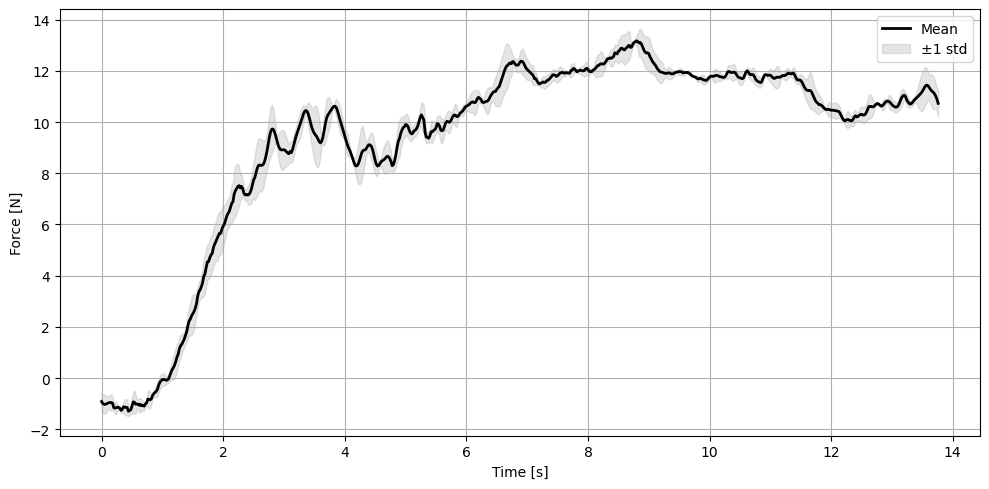

In [68]:
# 1. Extract the first 3 Trajectory=1 segments
segments = []
for s, e in zip(starts[:3], ends[:3]):
    segments.append(perf[s:e])

# 2. Cut all segments to the same minimum length
min_len = min(len(seg) for seg in segments)
segments = [seg[:min_len] for seg in segments]
segments = np.vstack(segments)

# 3. Calculate mean and std
mean_curve = np.mean(segments, axis=0)
std_curve = np.std(segments, axis=0)

# 4. Make a time axis for the trimmed segments
time_short = np.arange(min_len) / 50  # adjust if your sample rate is different

# 5. Plot all curves (thin and faded)
plt.figure(figsize=(10,5))
# for i, seg in enumerate(segments, 1):
#     plt.plot(time_short, seg, color='C0', alpha=0.3, linewidth=1)

# 6. Plot mean (thick)
plt.plot(time_short, mean_curve, color='k', linewidth=2, label='Mean')

# 7. Fill ±1 std
plt.fill_between(time_short, mean_curve-std_curve, mean_curve+std_curve,
                 color='gray', alpha=0.2, label='±1 std')

plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


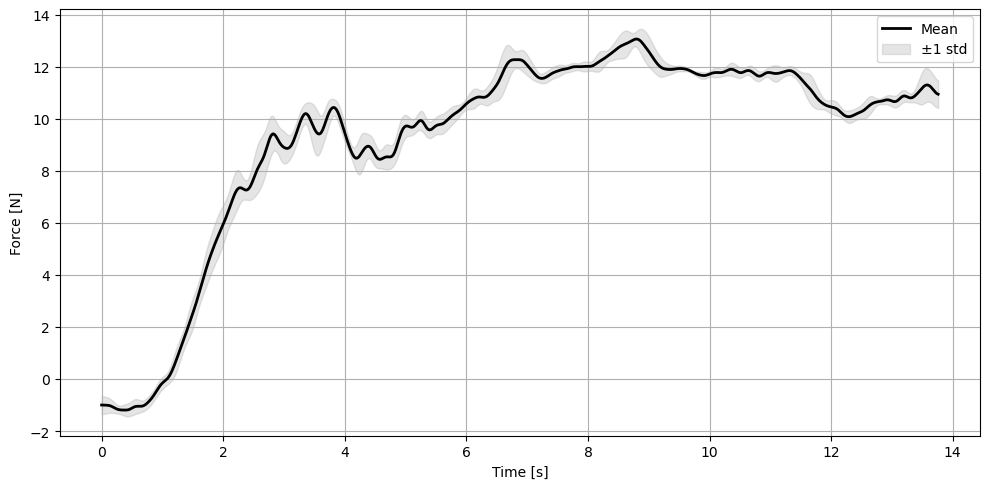

In [110]:
from scipy.ndimage import gaussian_filter1d

# 3. Calculate mean and std
mean_curve = np.mean(segments, axis=0)
std_curve = np.std(segments, axis=0)

# 4. Smooth curves
smooth_mean = gaussian_filter1d(mean_curve, sigma=3)  # sigma는 부드러움 정도 (2~5 추천)
smooth_std  = gaussian_filter1d(std_curve, sigma=3)

# 5. Make a time axis for the trimmed segments
time_short = np.arange(min_len) / 50  # adjust if your sample rate is different

# 6. Plot
plt.figure(figsize=(10,5))
plt.plot(time_short, smooth_mean, color='k', linewidth=2, label='Mean')
plt.fill_between(time_short, smooth_mean-smooth_std, smooth_mean+smooth_std,
                 color='gray', alpha=0.2, label='±1 std')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


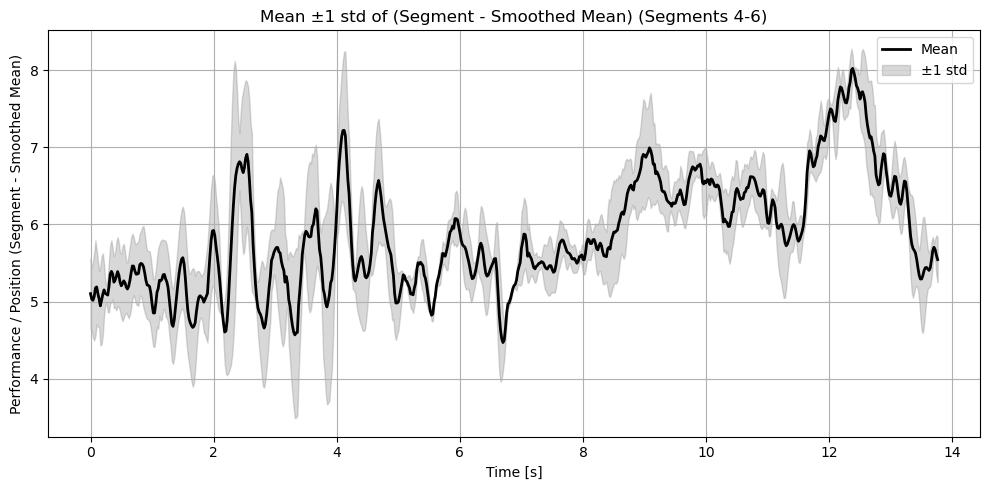

In [89]:
from scipy.ndimage import gaussian_filter1d

# 1. Smooth the mean_curve from earlier
smooth_mean = gaussian_filter1d(mean_curve, sigma=3)

# 2. Gather (segment - smoothed_mean) for segments 4, 5, 6
diff_segments = []
for s, e in zip(starts[3:6], ends[3:6]):
    seg_len = len(smooth_mean)
    if s + seg_len > len(perf_traj):
        continue
    diff = perf_traj[s:s+seg_len] - smooth_mean
    diff_segments.append(diff)

# 3. Cut all diffs to the same minimum length (for time axis alignment)
if diff_segments:
    min_len = min(len(seg) for seg in diff_segments)
    diff_segments = [seg[:min_len] for seg in diff_segments]
    diff_segments = np.vstack(diff_segments)

    # 4. Compute mean and std
    mean_diff = np.mean(diff_segments, axis=0)
    std_diff  = np.std(diff_segments, axis=0)
    time_short = np.arange(min_len) / 50  # sample rate = 50 Hz

    # 5. Plot
    plt.figure(figsize=(10,5))
    plt.plot(time_short, mean_diff, color='k', linewidth=2, label='Mean')
    plt.fill_between(time_short, mean_diff-std_diff, mean_diff+std_diff,
                     color='gray', alpha=0.3, label='±1 std')
    plt.xlabel('Time [s]')
    plt.ylabel('Performance / Position (Segment - Smoothed Mean)')
    plt.title('Mean ±1 std of (Segment - Smoothed Mean) (Segments 4-6)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


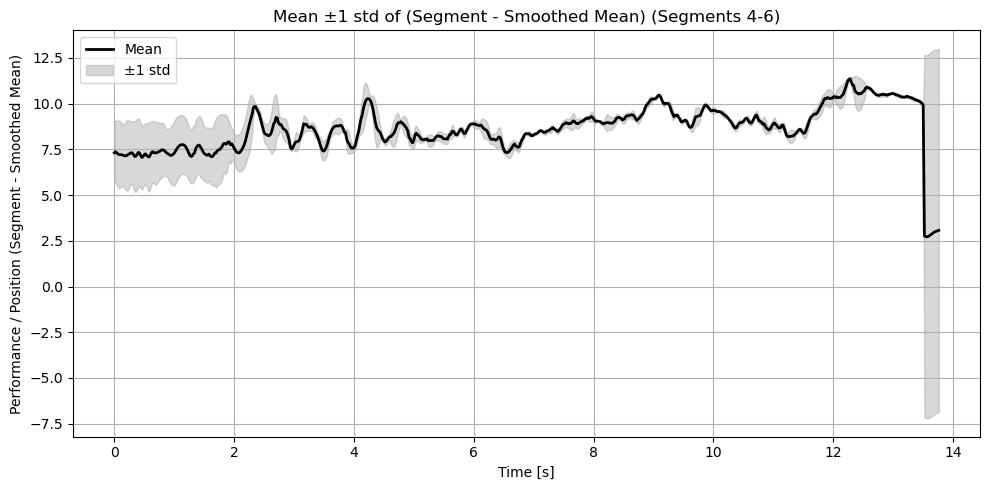

In [90]:
from scipy.ndimage import gaussian_filter1d

# 1. Smooth the mean_curve from earlier
smooth_mean = gaussian_filter1d(mean_curve, sigma=3)

# 2. Gather (segment - smoothed_mean) for segments 4, 5, 6
diff_segments = []
for s, e in zip(starts[6:9], ends[6:9]):
    seg_len = len(smooth_mean)
    if s + seg_len > len(perf_traj):
        continue
    diff = perf_traj[s:s+seg_len] - smooth_mean
    diff_segments.append(diff)

# 3. Cut all diffs to the same minimum length (for time axis alignment)
if diff_segments:
    min_len = min(len(seg) for seg in diff_segments)
    diff_segments = [seg[:min_len] for seg in diff_segments]
    diff_segments = np.vstack(diff_segments)

    # 4. Compute mean and std
    mean_diff = np.mean(diff_segments, axis=0)
    std_diff  = np.std(diff_segments, axis=0)
    time_short = np.arange(min_len) / 50  # sample rate = 50 Hz

    # 5. Plot
    plt.figure(figsize=(10,5))
    plt.plot(time_short, mean_diff, color='k', linewidth=2, label='Mean')
    plt.fill_between(time_short, mean_diff-std_diff, mean_diff+std_diff,
                     color='gray', alpha=0.3, label='±1 std')
    plt.xlabel('Time [s]')
    plt.ylabel('Performance / Position (Segment - Smoothed Mean)')
    plt.title('Mean ±1 std of (Segment - Smoothed Mean) (Segments 4-6)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Average (Segments 4-6): 5.9066
Average (Segments 7-9): 8.8996


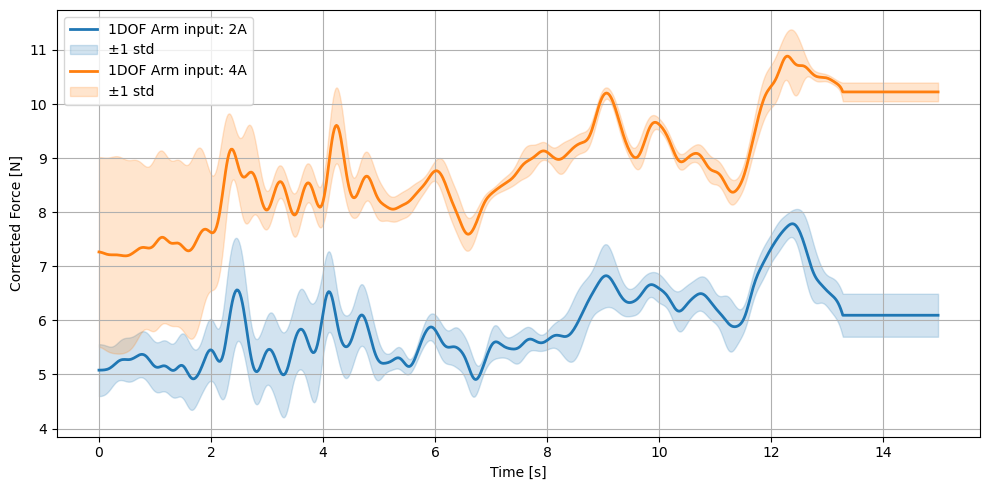

In [ ]:
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt

smooth_mean = gaussian_filter1d(mean_curve, sigma=3)
smoothing_sigma = 5  # adjust smoothing as needed

plt.figure(figsize=(10,5))

sample_rate = 50
pad_start_sec = 13.3
pad_end_sec = 15
pad_start = int(pad_start_sec * sample_rate)
pad_end = int(pad_end_sec * sample_rate)
target_len = pad_end  # up to 15 s

all_mean_values = []  # for saving averages

for diff_group, color, label, fill_label, idx_range in [
    ([], 'C0', '1DoF Arm input: 2A', '±1 std', (3, 6)),
    ([], 'C1', '1DoF Arm input: 4A', '±1 std', (6, 9))
]:
    diff_segments = []
    for s, e in zip(starts[idx_range[0]:idx_range[1]], ends[idx_range[0]:idx_range[1]]):
        seg_len = len(smooth_mean)
        if s + seg_len > len(perf_traj):
            continue
        diff = perf_traj[s:s+seg_len] - smooth_mean
        diff_segments.append(diff)

    if diff_segments:
        min_len = min(len(seg) for seg in diff_segments)
        diff_segments = [seg[:min_len] for seg in diff_segments]
        diff_segments = np.vstack(diff_segments)
        mean_diff = np.mean(diff_segments, axis=0)
        std_diff  = np.std(diff_segments, axis=0)
        # Smoothing
        mean_diff = gaussian_filter1d(mean_diff, sigma=smoothing_sigma)
        std_diff  = gaussian_filter1d(std_diff, sigma=smoothing_sigma)
        time_short = np.arange(min_len) / sample_rate

        # --- Padding from 13.3s to 15s with the last value ---
        if min_len < pad_end:
            pad_value = mean_diff[pad_start-1] if min_len > pad_start else mean_diff[-1]
            std_value = std_diff[pad_start-1] if min_len > pad_start else std_diff[-1]
            mean_diff = np.concatenate([
                mean_diff[:pad_start],
                np.full(pad_end - pad_start, pad_value)
            ])
            std_diff = np.concatenate([
                std_diff[:pad_start],
                np.full(pad_end - pad_start, std_value)
            ])
            time_short = np.arange(pad_end) / sample_rate
        else:
            mean_diff = mean_diff[:pad_end]
            std_diff = std_diff[:pad_end]
            time_short = time_short[:pad_end]

        # --- Print the average value over the full 15 seconds for this group ---
        avg_val = np.mean(mean_diff)
        print(f"Average (Segments {idx_range[0]+1}-{idx_range[1]}): {avg_val:.4f}")
        all_mean_values.append(avg_val)

        plt.plot(time_short, mean_diff, color=color, linewidth=2, label=label)
        plt.fill_between(time_short, mean_diff-std_diff, mean_diff+std_diff,
                         color=color, alpha=0.2, label=fill_label)

plt.xlabel('Time [s]')
plt.ylabel('Corrected Force [N]')
# plt.title('Smoothed Mean ±1 std of (Segment - Smoothed Mean)\nSegments 4-6 and 7-9 (padded after 13s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [107]:
expected = 4.45
measured = 5.906

abs_error = abs(measured - expected)
rel_error = abs_error / abs(expected)

print(f"Absolute error: {abs_error:.4f}")
print(f"Relative error: {rel_error*100:.2f} %")

expected = 8.9
measured = 8.8996

abs_error = abs(measured - expected)
rel_error = abs_error / abs(expected)

print(f"Absolute error: {abs_error:.4f}")
print(f"Relative error: {rel_error*100:.2f} %")

Absolute error: 1.4560
Relative error: 32.72 %
Absolute error: 0.0004
Relative error: 0.00 %


# deprecated

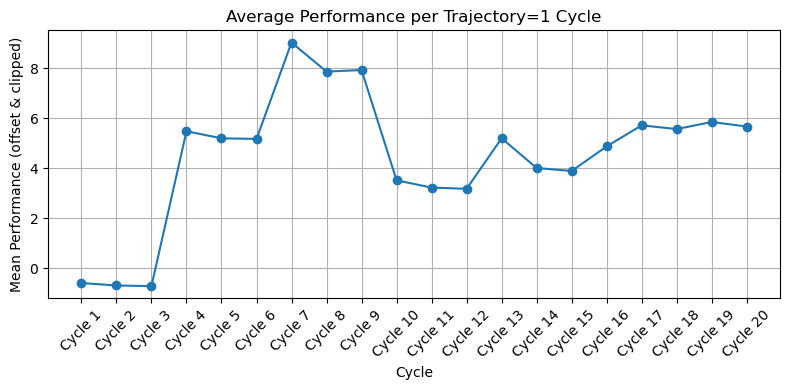

-0.6718251057856524
5.287478855087428
8.284374316066968
[np.float64(5.202090450665051), np.float64(5.176131932514461)]


In [21]:
# 1) 사이클별 평균 계산 (from before)
edges = np.where((traj[:-1] == 1) & (traj[1:] == 0))[0] + 1

cycle_nums = []
cycle_avgs = []
start = 0
for i, edge in enumerate(edges, start=1):
    # seg  = perf_off_clipped[start:edge]
    seg  = perf[start:edge]  - 10
    mask = traj[start:edge] == 1
    avg  = seg[mask].mean() if mask.any() else 0
    cycle_nums.append(i)
    cycle_avgs.append(avg)
    start = edge

# 2) 플롯: x축에 “Cycle 1”, “Cycle 2”, …
plt.figure(figsize=(8,4))
plt.plot(cycle_nums, cycle_avgs, marker='o', linestyle='-')
plt.xlabel('Cycle')
plt.ylabel('Mean Performance (offset & clipped)')
plt.title('Average Performance per Trajectory=1 Cycle')

# x축 눈금과 라벨 설정
labels = [f'Cycle {n}' for n in cycle_nums]
plt.xticks(cycle_nums, labels, rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()
print(np.average(cycle_avgs[:3]))
print(np.average(cycle_avgs[3:6]))
print(np.average(cycle_avgs[6:9]))

print(cycle_avgs[4:6])